In [1]:
using Pkg
Pkg.activate("D://ATIS3//Project.toml") # change path 
Pkg.instantiate()

 Activating environment at `D:\ATIS3\Project.toml`


In [2]:
using JuMP, LinearAlgebra, Plots, StatsPlots, CPLEX, Statistics, CSV, DataFrames

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278


## Define parameter

In [30]:
#read scenario data
scenarios_hexagons = CSV.read("scenarios_multinomial.csv", DataFrame)
scenarios_prices = CSV.read("priceScenarions3.csv", DataFrame)

hexagons = names(scenarios_hexagons)[1:length(names(scenarios_hexagons))-1] # vector of hexagons (strings)
hours = names(scenarios_prices)[3:length(names(scenarios_prices))] #vector of hours for charging (strings)
car_kWh = 30 # capacity of each car

#demand mxn (m=hexagon, n=scenario) in kWh summe über car*max_kWh*(1-SOC)
SOC = Array(CSV.read("SoC_6.csv", DataFrame))
one_mat = ones(size(SOC,1), size(SOC,2))
demand_cars = transpose(convert(Matrix,scenarios_hexagons[:,hexagons]))
demand_kWh = demand_cars.*car_kWh.*(one_mat.-SOC)

#prices mxn (m=hours, n=scenario)
prices = transpose(convert(Matrix,scenarios_prices[:,hours]))
prices = prices/100
# prices[prices.<0] .= 0

probability_hexagons = transpose(scenarios_hexagons.probs) # probabilities for each scenario (#cars per hexagon)
probability_prices = transpose(scenarios_prices.Probability) # probabilities for each scenario (timeseries prices)

P = [3.7, 11, 22] # different charger types in kW
charger_cost_fix = [1500, 1700, 1900] # investment cost for charger 3 kW, 7 kW und 11 kW in €
charger_cost_annuity = charger_cost_fix./(3*365)
charger_cost = charger_cost_annuity./P # investment cost for charger 3 kW, 7 kW und 11 kW in €/kW
opportunity_cost = 0.4 # cost of demand not served

alpha = 0.05
beta = 0

prices

7×7 Array{Float64,2}:
 0.4456   0.2787  0.3763  0.1739  0.5     0.4296  0.5574
 0.426    0.2701  0.3636  0.1651  0.4663  0.417   0.5383
 0.3923   0.198   0.3157  0.0402  0.3928  0.3677  0.4934
 0.3751   0.004   0.3202  0.3144  0.308   0.1765  0.4487
 0.3718  -0.0299  0.301   0.2566  0.3023  0.1286  0.4807
 0.3654  -0.0519  0.2905  0.2405  0.2987  0.1427  0.4749
 0.3578  -0.0745  0.2804  0.2411  0.2871  0.1445  0.4459

## Build the scenario tree

In [31]:
## Build Probabilities
comb_probability = []
for prob_d in probability_hexagons
    for prob_p in probability_prices
        push!(comb_probability,prob_d*prob_p)
    end
end
comb_probability = convert(Array{Float64,1}, comb_probability)

## Build Demand kWh and Demand Cars
num_hex = size(demand_kWh,1)
num_Scen_Dem = size(demand_kWh,2)
num_Scen_Pri = size(prices,2)

comb_demand_kWh = zeros((num_hex, num_Scen_Dem*num_Scen_Pri))
comb_demand_cars = zeros((num_hex, num_Scen_Dem*num_Scen_Pri))
comb_SOC = zeros((num_hex, num_Scen_Dem*num_Scen_Pri))
counter = 0

for num_d in 1:num_Scen_Dem
    for num_p in 1:num_Scen_Pri
        counter += 1
        comb_demand_kWh[:,counter] = demand_kWh[:,num_d]
        comb_demand_cars[:,counter] = demand_cars[:,num_d]
        comb_SOC[:,counter] = SOC[:,num_d]
    end
end

## Build Prices
num_Scen_Dem = size(demand_kWh,2)
num_Scen_Pri = size(prices,2)

comb_prices = zeros((length(hours), num_Scen_Dem*num_Scen_Pri))
counter = 0

for num_d in 1:num_Scen_Dem
    for num_p in 1:num_Scen_Pri
        counter += 1
        comb_prices[:,counter] = prices[1:length(hours),num_p]
    end
end


## Build model

In [32]:
function charger_siting(comb_SOC, hexagons, hours, car_kWh, comb_demand_cars, comb_demand_kWh, comb_prices, 
        comb_probability, P, charger_cost, opportunity_cost, alpha, beta)
    
    opprtunity_cost = 0
    
    # Define Sets
    Γ = Array{Int}(1:length(hexagons)) # Gamma, Set with hexagons
    Σ = Array{Int}(1:length(P)) # Sigma, Set with charger types 
    Ω = Array{Int}(1:length(comb_probability)) # Omega, Set with scenarios
    Τ = Array{Int}(1:length(hours)) # Lambda, Set with scenarios for prices

    # Initialize model    
    m = Model(CPLEX.Optimizer)
    
    # η
    @variable(m, η) 
    @variable(m, 0 <= s[k=Ω])
    β = beta 
    α = alpha
    
    # Define variables
    @variable(m, 0 <= x_charger[i=Γ,j=Σ],Int) # number of specific charger type in each hexagon
    @variable(m, 0 <= E_supplied[i=Γ,j=Σ,k=Ω,t=Τ]) # supplied energy in each hexagon kWh
    @variable(m, 0 <= E_not_supplied[i=Γ,k=Ω])     # demand not covered kWh
    @variable(m, 0 <= cars_supplied[i=Γ,j=Σ,k=Ω],Int)
    @variable(m, 0 <= cars_not_supplied[i=Γ,k=Ω],Int)

    # expressions for total costs
    @expression(m, invest_cost[i=Γ,j=Σ], charger_cost[j].*x_charger[i,j].*P[j]) # first stage investment cost
    @expression(m, charging_opportunity_cost[i=Γ,k=Ω], opportunity_cost.*E_not_supplied[i,k].*comb_probability[k])
    # @expression(m, grid_usage[i=Γ,k=Ω,t=Τ], 0.1*sum(E_supplied[i,j,k,t] for j in Σ)^(2).*comb_probability[k])
    @expression(m, grid_usage[i=Γ,k=Ω,t=Τ], 0.1*sum(E_supplied[i,j,k,t] for j in Σ).*comb_probability[k])
    @expression(m, charging_cost[i=Γ,j=Σ,k=Ω,t=Τ], comb_prices[t,k].*E_supplied[i,j,k,t].*comb_probability[k]) #minimize cost of charging
    
    # expressions for objective function
    @expression(m, total_cost, (-1)*(  sum(invest_cost) 
                                     + sum(charging_cost)
                                     + sum(charging_opportunity_cost) 
                                     + sum(grid_usage)
                                     )
                )
    @expression(m, cVAR, η-(1/(1-α) * dot(comb_probability, s)))
    @objective(m, Max, (1-β)*total_cost + β*cVAR)
    
    # Constraints
    # Eq. Balance equation: Demand in each hexagon has to equal demand. Loss of load is possible
    @constraint(m, eq_balance[i=Γ,k=Ω], sum(E_supplied[i,j,k,t] for j in Σ for t in Τ) + E_not_supplied[i,k] == comb_demand_kWh[i,k])

    # Eq. energy limit: rated_power*chargingtime must not exeed energy
    @constraint(m, eq_cap[i=Γ,j=Σ,k=Ω,t=Τ], E_supplied[i,j,k,t] <= x_charger[i,j].*P[j])

    # Eq. supplied cars and not supplied cars have to equal amount of cars in each hexagon
    @constraint(m, eq_cars_supplied[i=Γ,k=Ω],     sum(cars_supplied[i,j,k] for j in Σ) 
                                                    + cars_not_supplied[i,k]
                                                   == comb_demand_cars[i,k])

    # Eq. maximum one car per charging station
    @constraint(m, eq_max_cars[i=Γ,j=Σ,k=Ω], cars_supplied[i,j,k] <= x_charger[i,j])

    # Eq. 
    @constraint(m, eq_max_supply[i=Γ,j=Σ,k=Ω], sum(E_supplied[i,j,k,t] for t in Τ) == cars_supplied[i,j,k].*car_kWh.*(1-comb_SOC[i,k]))

    # η Constraint
    @constraint(m, cVAR_constraint[k=Ω], η + (sum((charger_cost[j].*x_charger[i,j].*P[j]) for j in Σ for i in Γ) 
                                           +  sum((opportunity_cost.*E_not_supplied[i,k]) for i in Γ)
                                           # +  sum(0.1*sum(E_supplied[i,j,k,t] for j in Σ)^(2) for i in Γ for t in Τ)
                                           +  0.1*sum(E_supplied[i,j,k,t] for j in Σ for i in Γ for t in Τ)
                                           +  sum((comb_prices[t,k].*E_supplied[i,j,k,t]) for j in Σ for i in Γ for t in Τ))
                                           <= s[k])

    # Run optimization
    optimize!(m)

    # Evaluate resuluts
    obj = objective_value(m)
    charger_in_hex = value.(x_charger)
    
    cost1 = value.(sum(invest_cost)) 
    cost2 = value.(sum(charging_cost))
    cost3 = value.(sum(charging_opportunity_cost)) 
    cost4 = value.(sum(grid_usage))
    
    println("cost invest:  ", cost1)
    println("cost charging:  ",cost2)
    println("cost opportunity:  ",cost3)
    println("cost grid:  ",cost4)
    
    res_total_cost = value.(total_cost)
    cvar = value.(cVAR)
    
    return charger_in_hex, E_not_supplied, res_total_cost, cvar
end

charger_siting (generic function with 1 method)

## Run model Base Case 

In [33]:
charger_in_hex, E_not_supplied, res_total_cost, cvar = charger_siting(
    comb_SOC, hexagons, hours, car_kWh, comb_demand_cars, comb_demand_kWh, comb_prices, 
        comb_probability, P, charger_cost, opportunity_cost, alpha, beta)

println(round.(charger_in_hex))
println("cvar:",cvar)
println("total_cost:",res_total_cost)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
Found incumbent of value -4370.307000 after 0.03 sec. (14.03 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 39424 rows and 35414 columns.
MIP Presolve modified 2646 coefficients.
Aggregator did 1722 substitutions.
Reduced MIP has 77042 rows, 69122 columns, and 266168 nonzeros.
Reduced MIP has 1625 binaries, 7745 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.20 sec. (189.46 ticks)
Probing time = 0.05 sec. (4.66 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 2576 rows and 2327 columns.
Reduced MIP has 74466 rows, 66795 columns, and 257250 nonzeros.
Reduced MIP has 1367 binaries, 7678 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.16 sec. (130.44 ticks)
Probing time = 0.05 sec. (4.72 ticks)
Clique table members: 448.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution

## Run Sensitivity analysis 

### Opportunity cost 

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
Found incumbent of value -1092.576750 after 0.02 sec. (14.03 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 39424 rows and 35414 columns.
MIP Presolve modified 2646 coefficients.
Aggregator did 1722 substitutions.
Reduced MIP has 77042 rows, 69122 columns, and 266168 nonzeros.
Reduced MIP has 1625 binaries, 7745 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.22 sec. (189.46 ticks)
Probing time = 0.03 sec. (4.66 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 2576 rows and 2327 columns.
Reduced MIP has 74466 rows, 66795 columns, and 257250 nonzeros.
Reduced MIP has 1367 binaries, 7678 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.19 sec. (130.44 ticks)
Probing time = 0.03 sec. (4.72 ticks)
Clique table members: 448.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
Found incumbent of value -6555.460500 after 0.03 sec. (14.03 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 39424 rows and 35414 columns.
MIP Presolve modified 2646 coefficients.
Aggregator did 1722 substitutions.
Reduced MIP has 77042 rows, 69122 columns, and 266168 nonzeros.
Reduced MIP has 1625 binaries, 7745 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.28 sec. (189.46 ticks)
Probing time = 0.03 sec. (4.66 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 2576 rows and 2327 columns.
Reduced MIP has 74466 rows, 66795 columns, and 257250 nonzeros.
Reduced MIP has 1367 binaries, 7678 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.27 sec. (130.45 ticks)
Probing time = 0.06 sec. (4.72 ticks)
Clique table members: 448.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution

cost grid:  1092.5767499999997


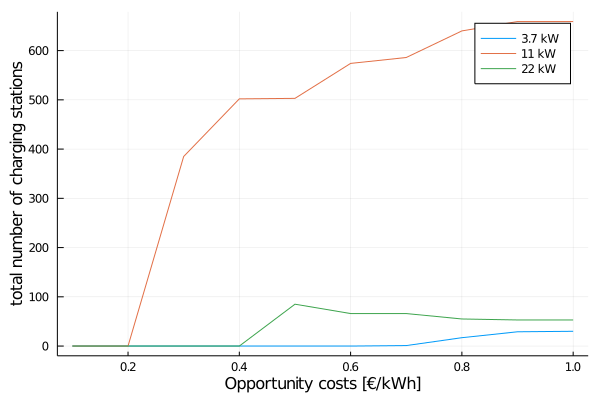

In [34]:
opp_list = [0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 1.00]
charger_per_type_dict = Dict()
for opportunity_cost in opp_list
    charger_in_hex, E_not_supplied, res_total_cost, cvar = charger_siting(
        comb_SOC, hexagons, hours, car_kWh, comb_demand_cars, comb_demand_kWh, comb_prices,
        comb_probability, P, charger_cost, opportunity_cost, alpha, beta)
    
    I, J = axes(charger_in_hex)
    xx = zeros(length(I),length(J))
    [xx[i,j] = charger_in_hex[i,j] for i in I, j in J]
    charger_per_type = sum(xx, dims=1)
    charger_per_type_dict[string(opportunity_cost)] = charger_per_type
    
end

charger_per_type_dict

auswertung = []
for i in opp_list
    values = charger_per_type_dict[string(i)]
    push!(auswertung, values)
end
auswertung

auswertung3 = vcat(auswertung...)

plot(opp_list',auswertung3, xlabel="Opportunity costs [€/kWh]", ylabel="total number of charging stations",label=["3.7 kW" "11 kW" "22 kW"])

### Charging hours 

In [ ]:
hours_lst = [["22", "23", "24", "1", "2", "3", "4"],
            ["23", "24", "1", "2", "3", "4"],
            ["24", "1", "2", "3", "4"],
            ["1", "2", "3", "4"],
            ["2", "3", "4"],
            ["3", "4"]]
charger_hours_dict = Dict()
energy_hours_dict = Dict()
cost_hours_dict = Dict()
cvar_hours_dict = Dict()
for hours in hours_lst
    charger_in_hex, E_not_supplied, res_total_cost, cvar = charger_siting(
        comb_SOC, hexagons, hours, car_kWh, comb_demand_cars, comb_demand_kWh, comb_prices,
        comb_probability, P, charger_cost, opportunity_cost, alpha, beta)
    charger_hours_dict[length(hours)] = charger_in_hex
    energy_hours_dict[length(hours)] = value.(E_not_supplied)
    cost_hours_dict[length(hours)] = res_total_cost
    cvar_hours_dict[length(hours)] = cvar
end

In [ ]:
for hours in hours_lst
    println(length(hours), " hours: ",
        "charger_in_hex = ", sum(charger_hours_dict[length(hours)]),
        " / Energy not supplied = ", sum(energy_hours_dict[length(hours)]),
        " / total cost = ", cost_hours_dict[length(hours)],
        " / Cvar = ", cvar_hours_dict[length(hours)]
    )
end

In [ ]:
for (key, value) in charger_hours_dict
    CSV.write(
        string("sensitivity/hours/charger_in_hex_",string(key),".csv"),
        DataFrame(value)
    )
end
for (key, value) in energy_hours_dict
    CSV.write(
        string("sensitivity/hours/E_not_supplied_",string(key),".csv"),
        DataFrame(value)
    )
end
CSV.write(
        string("sensitivity/hours/cost_dict.csv"),
        cost_hours_dict
    )
CSV.write(
        string("sensitivity/hours/cvar_dict.csv"),
        cvar_hours_dict
    )

In [ ]:
println(opportunity_cost)
println(hours)

In [ ]:
op_cost_lst = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
charger_op_cost_dict = Dict()
energy_op_cost_dict = Dict()
cost_op_cost_dict = Dict()
cvar_op_cost_dict = Dict()
for opportunity_cost in op_cost_lst
    charger_in_hex, E_not_supplied, res_total_cost, cvar= charger_siting(
        comb_SOC, hexagons, hours, car_kWh, comb_demand_cars, comb_demand_kWh, comb_prices,
        comb_probability, P, charger_cost, opportunity_cost, alpha, beta)
    charger_op_cost_dict[opportunity_cost] = charger_in_hex
    energy_op_cost_dict[opportunity_cost] = value.(E_not_supplied)
    cost_op_cost_dict[opportunity_cost] = res_total_cost
    cvar_op_cost_dict[opportunity_cost] = cvar
end

In [ ]:
for opportunity_cost in op_cost_lst
    println(opportunity_cost, 
        " Opportunity Cost: ", "charger_in_hex = ", sum(charger_op_cost_dict[opportunity_cost]),
        " / Energy not supplied = ", sum(energy_op_cost_dict[opportunity_cost]),
        " / total cost = ", cost_op_cost_dict[opportunity_cost],
        " / Cvar = ", cvar_op_cost_dict[opportunity_cost]
    )
end

In [ ]:
for (key, value) in charger_op_cost_dict
    CSV.write(
        string("sensitivity/opportunity/charger_in_hex_",string(key),".csv"),
        DataFrame(value)
    )
end
for (key, value) in energy_op_cost_dict
    CSV.write(
        string("sensitivity/opportunity/E_not_supplied_",string(key),".csv"),
        DataFrame(value)
    )
end
CSV.write(
        string("sensitivity/opportunity/cost_dict.csv"),
        cost_op_cost_dict
    )
CSV.write(
        string("sensitivity/opportunity/cvar_dict.csv"),
        cvar_op_cost_dict
    )

In [ ]:
println(opportunity_cost)
println(hours)

In [ ]:
beta_lst = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
charger_beta_dict = Dict()
energy_beta_dict = Dict()
cost_beta_dict = Dict()
cvar_beta_dict = Dict()
for beta in beta_lst
    charger_in_hex, E_not_supplied, res_total_cost, cvar= charger_siting(
        comb_SOC, hexagons, hours, car_kWh, comb_demand_cars, comb_demand_kWh, comb_prices,
        comb_probability, P, charger_cost, opportunity_cost, alpha, beta)
    charger_beta_dict[beta] = charger_in_hex
    energy_beta_dict[beta] = value.(E_not_supplied)
    cost_beta_dict[beta] = res_total_cost
    cvar_beta_dict[beta] = cvar
end

In [ ]:
for beta in beta_lst
    println(beta, 
        " beta: ", "charger_in_hex = ", sum(charger_beta_dict[beta]),
        " / Energy not supplied = ", sum(energy_beta_dict[beta]),
        " / total cost = ", cost_beta_dict[beta],
        " / Cvar = ", cvar_beta_dict[beta]
    )
end

In [ ]:
for (key, value) in charger_beta_dict
    CSV.write(
        string("sensitivity/beta/charger_in_hex_",string(key),".csv"),
        DataFrame(value)
    )
end
for (key, value) in energy_beta_dict
    CSV.write(
        string("sensitivity/beta/E_not_supplied_",string(key),".csv"),
        DataFrame(value)
    )
end
CSV.write(
        string("sensitivity/beta/cost_dict.csv"),
        cost_beta_dict
    )
CSV.write(
        string("sensitivity/beta/cvar_dict.csv"),
        cvar_beta_dict
    )

charger_cost = [600, 400, 100]# investment cost for charger 3 kW, 7 kW und 11 kW in €/kW
charger_cost_delta = 600
charger_cost_dict = Dict()
energy_dict = Dict()
for i in range(0, step=100, stop=charger_cost_delta)
    charger_in_hex, x_charger, E_not_supplied, = charger_siting(
        SOC, hexagons, hours, car_kWh, demand_cars, demand_kWh, prices,
        probability, P, charger_cost.+i, opportunity_cost, alpha, beta)
    charger_cost_dict[charger_cost.+i] = charger_in_hex
    energy_dict[charger_cost.+i] = value.(E_not_supplied)
end

for key in keys(charger_cost_dict)
    println(key, " Charger Cost: ", "charger_in_hex = ", sum(charger_cost_dict[key]),
        " / Energy not supplied = ", sum(energy_dict[key]))
end